In [1]:
%load_ext autoreload
%autoreload 2

In [90]:
import lib.assembly_graph
import lib.plot
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import scipy as sp

# Saw-horse

In [1898]:
seed = {
    'AACCG': ['ACCGG'],
    'ACCGG': ['CCGGG', 'CCGGA'],
    'TACCG': ['ACCGG'],
}
downstream, upstream = lib.assembly_graph.build_full_from_seed_graph(seed)

observed_depth = lib.assembly_graph.add_reverse_complement_depth({
    'AACCG': 9,
    'ACCGG': 10,
    'CCGGG': 9,
    'CCGGA': 1,
    'TACCG': 1,
})

assert lib.assembly_graph.mapping_all_upstream(upstream)
upstream, observed_depth

(defaultdict(list,
             {'ACCGG': ['AACCG', 'TACCG'],
              'CGGTT': ['CCGGT'],
              'CCGGG': ['ACCGG'],
              'CCGGT': ['CCCGG', 'TCCGG'],
              'CCGGA': ['ACCGG'],
              'CGGTA': ['CCGGT']}),
 defaultdict(<function lib.assembly_graph.add_reverse_complement_depth.<locals>.<lambda>()>,
             {'AACCG': 9,
              'CGGTT': 9,
              'ACCGG': 10,
              'CCGGT': 10,
              'CCGGG': 9,
              'CCCGG': 9,
              'CCGGA': 1,
              'TCCGG': 1,
              'TACCG': 1,
              'CGGTA': 1}))

In [1899]:
depth0 = pd.Series(observed_depth).astype(float)
n = len(depth0)
depth0

AACCG     9.0
CGGTT     9.0
ACCGG    10.0
CCGGT    10.0
CCGGG     9.0
CCCGG     9.0
CCGGA     1.0
TCCGG     1.0
TACCG     1.0
CGGTA     1.0
dtype: float64

In [1900]:
# "Directed" graph with each node pointing to nodes that are downstream.
# If I want a graph of each node pointing upstream, that's just dgraph.T
# After the *first* step, where I distribute each nodes depth equally upstream
# and downstream, I'm going to need two contingency tables, because
# uflow != dflow.T

linked_5p_to_3p = downstream

dgraph_5p_to_3p = pd.DataFrame(np.zeros((n, n)), index=depth0.index, columns=depth0.index)
for k in dgraph_5p_to_3p:
    dgraph_5p_to_3p.loc[k, linked_5p_to_3p[k]] = 1

<AxesSubplot:>

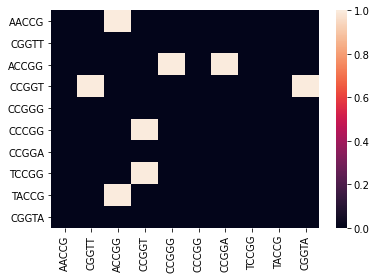

In [1901]:
l_contingency = dgraph_5p_to_3p.copy()
r_contingency = dgraph_5p_to_3p.T.copy()

sns.heatmap(l_contingency)

<AxesSubplot:>

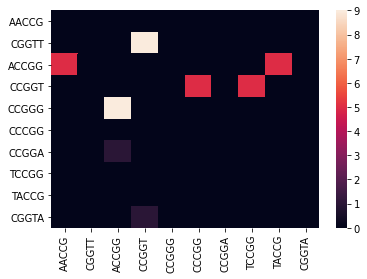

In [1902]:
# Initialization

send_to_r = r_contingency
send_to_l = l_contingency

# This is not actually the flow,
# because it's not proportional to depth...yet.

depth = depth0

total_from_l = send_to_r.sum()
total_from_r = send_to_l.sum()

# When it's not initialization
# we'll update depth here.

send_to_r_next = (send_to_l / total_from_r).multiply(depth, axis=1).T
send_to_l_next = (send_to_r / total_from_l).multiply(depth, axis=1).T

# Initialization done
send_to_r = send_to_r_next.fillna(0)
send_to_l = send_to_l_next.fillna(0)

sns.heatmap(send_to_r)

# table = pd.DataFrame(dict(depth=depth, in_degree_r=total_from_r, in_degree_l=total_from_l, out_degree_r=send_to_r.sum(1), out_degree_l=send_to_l.sum(1)))
# table

In [1949]:
# One Step
total_from_l = send_to_r.sum()
total_from_r = send_to_l.sum()

# Graveyard of depths past.
# depth = np.sqrt(np.mean((np.array([total_from_r, total_from_l, depth]) + 1)**2))  #  (depth0 * gamma + depth + total_from_r + total_from_l) / (3 + gamma)
# next_depth = np.cbrt((total_from_r + pc) * (total_from_l + pc) * (depth + pc)) - pc
# depth = (
#     np.exp(
#         (
#             np.log(total_from_r + pc) +
#             np.log(total_from_l + pc) +
#             np.log(depth + pc)
#         ) / (3 + pc)
#     )
# )

# Update depth
gamma = 1
next_depth = (total_from_r + total_from_l + (gamma * depth)) / (2 + gamma)
# Scale the depth so there's no overall loss.
depth = next_depth * (depth.sum() / next_depth.sum())

send_to_r_next = (send_to_l / total_from_r).multiply(depth, axis=1).T
send_to_l_next = (send_to_r / total_from_l).multiply(depth, axis=1).T

send_to_r = send_to_r_next.fillna(0)
send_to_l = send_to_l_next.fillna(0)

# Step done

# sns.heatmap(send_to_r)
# plt.plot(depth)
# plt.ylim(0)
depth

# table = pd.DataFrame(dict(depth=depth, in_degree_r=total_from_r, in_degree_l=total_from_l, out_degree_r=send_to_r.sum(1), out_degree_l=send_to_l.sum(1)))
# table

AACCG     6.817487
CGGTT     6.817487
ACCGG    12.426407
CCGGT    12.426407
CCGGG     6.817487
CCCGG     6.817487
CCGGA     1.969310
TCCGG     1.969310
TACCG     1.969310
CGGTA     1.969310
dtype: float64

# Cycle w/ Switch-back

In [1546]:
seed = {
    'ACCCG': ['CCCGG'],
    'CCCGG': ['CCGGT'],
    'CCGGT': ['CGGTA'],
    'CGGTA': ['GGTAC'],
    'GGTAC': ['GTACC'],
    'GTACC': ['TACCC'],
    'TACCC': ['ACCCG'],
}
downstream, upstream = lib.assembly_graph.build_full_from_seed_graph(seed)

observed_depth = lib.assembly_graph.add_reverse_complement_depth({
    'ACCCG': 1,
    'CCCGG': 1,
    'CCGGT': 1,
    'CGGTA': 1,
    'GGTAC': 1,
    'GTACC': 1,
    'TACCC': 1,
})

assert lib.assembly_graph.mapping_all_upstream(upstream)
upstream, observed_depth

(defaultdict(list,
             {'CCCGG': ['ACCCG'],
              'CGGGT': ['CCGGG'],
              'CCGGT': ['CCCGG'],
              'CCGGG': ['ACCGG'],
              'CGGTA': ['CCGGT'],
              'ACCGG': ['TACCG'],
              'GGTAC': ['CGGTA', 'GGGTA'],
              'TACCG': ['GTACC'],
              'GTACC': ['GGTAC', 'GGTAC'],
              'TACCC': ['GTACC'],
              'ACCCG': ['TACCC'],
              'GGGTA': ['CGGGT']}),
 defaultdict(<function lib.assembly_graph.add_reverse_complement_depth.<locals>.<lambda>()>,
             {'ACCCG': 1,
              'CGGGT': 1,
              'CCCGG': 1,
              'CCGGG': 1,
              'CCGGT': 1,
              'ACCGG': 1,
              'CGGTA': 1,
              'TACCG': 1,
              'GGTAC': 1,
              'GTACC': 1,
              'TACCC': 1,
              'GGGTA': 1}))

In [1547]:
depth0 = pd.Series(observed_depth).astype(float)
n = len(depth0)
depth0

ACCCG    1.0
CGGGT    1.0
CCCGG    1.0
CCGGG    1.0
CCGGT    1.0
ACCGG    1.0
CGGTA    1.0
TACCG    1.0
GGTAC    1.0
GTACC    1.0
TACCC    1.0
GGGTA    1.0
dtype: float64

In [1548]:
# "Directed" graph with each node pointing to nodes that are downstream.
# If I want a graph of each node pointing upstream, that's just dgraph.T
# After the *first* step, where I distribute each nodes depth equally upstream
# and downstream, I'm going to need two contingency tables, because
# uflow != dflow.T

linked_5p_to_3p = downstream

dgraph_5p_to_3p = pd.DataFrame(np.zeros((n, n)), index=depth0.index, columns=depth0.index)
for k in dgraph_5p_to_3p:
    dgraph_5p_to_3p.loc[k, linked_5p_to_3p[k]] = 1

<AxesSubplot:>

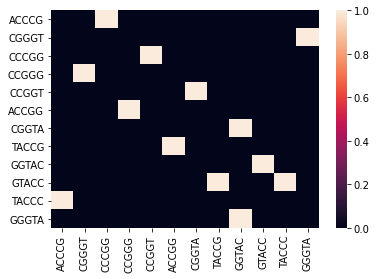

In [1549]:
l_contingency = dgraph_5p_to_3p.copy()
r_contingency = dgraph_5p_to_3p.T.copy()

sns.heatmap(l_contingency)

<AxesSubplot:>

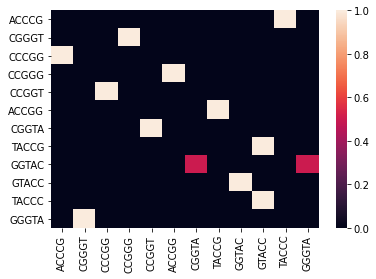

In [1734]:
# Initialization

send_to_r = r_contingency
send_to_l = l_contingency

# This is not actually the flow,
# because it's not proportional to depth...yet.

depth = depth0

total_from_l = send_to_r.sum()
total_from_r = send_to_l.sum()

# When it's not initialization
# we'll update depth here.

send_to_r_next = (send_to_l / total_from_r).multiply(depth, axis=1).T
send_to_l_next = (send_to_r / total_from_l).multiply(depth, axis=1).T

# Initialization done
send_to_r = send_to_r_next.fillna(0)
send_to_l = send_to_l_next.fillna(0)

sns.heatmap(send_to_r)

# table = pd.DataFrame(dict(depth=depth, in_degree_r=total_from_r, in_degree_l=total_from_l, out_degree_r=send_to_r.sum(1), out_degree_l=send_to_l.sum(1)))
# table

In [1816]:
# One Step
total_from_l = send_to_r.sum()
total_from_r = send_to_l.sum()

# Graveyard of depths past.
# depth = np.sqrt(np.mean((np.array([total_from_r, total_from_l, depth]) + 1)**2))  #  (depth0 * gamma + depth + total_from_r + total_from_l) / (3 + gamma)
# next_depth = np.cbrt((total_from_r + pc) * (total_from_l + pc) * (depth + pc)) - pc
# depth = (
#     np.exp(
#         (
#             np.log(total_from_r + pc) +
#             np.log(total_from_l + pc) +
#             np.log(depth + pc)
#         ) / (3 + pc)
#     )
# )

# Update depth
gamma = 1
next_depth = (total_from_r + total_from_l + (gamma * depth)) / (2 + gamma)
# Scale the depth so there's no overall loss.
depth = next_depth * (depth.sum() / next_depth.sum())

send_to_r_next = (send_to_l / total_from_r).multiply(depth, axis=1).T
send_to_l_next = (send_to_r / total_from_l).multiply(depth, axis=1).T

send_to_r = send_to_r_next.fillna(0)
send_to_l = send_to_l_next.fillna(0)

# Step done

# sns.heatmap(send_to_r)
# plt.plot(depth)
# plt.ylim(0)
depth

# table = pd.DataFrame(dict(depth=depth, in_degree_r=total_from_r, in_degree_l=total_from_l, out_degree_r=send_to_r.sum(1), out_degree_l=send_to_l.sum(1)))
# table

ACCCG    0.857647
CGGGT    0.857647
CCCGG    0.857952
CCGGG    0.857952
CCGGT    0.857647
ACCGG    0.857647
CGGTA    0.856963
TACCG    0.856963
GGTAC    1.712828
GTACC    1.712828
TACCC    0.856963
GGGTA    0.856963
dtype: float64

# Tall saw-horse

In [1950]:
seed = {
    'AACCG': ['ACCGG'],
    'ACCGG': ['CCGGG', 'CCGGA'],
    'TACCG': ['ACCGG'],
    'TAACC': ['AACCG'],
    'TTACC': ['TACCG'],
    'CCGGG': ['CGGGT'],
    'CCGGA': ['CGGAT'],
}
downstream, upstream = lib.assembly_graph.build_full_from_seed_graph(seed)

observed_depth = lib.assembly_graph.add_reverse_complement_depth({
    'AACCG': 9,
    'ACCGG': 10,
    'CCGGG': 9,
    'CCGGA': 1,
    'TACCG': 1,
    'TAACC': 9,
    'TTACC': 1,
    'CGGGT': 9,
    'CGGAT': 1,
})

assert lib.assembly_graph.mapping_all_upstream(upstream)
upstream, observed_depth

(defaultdict(list,
             {'ACCGG': ['AACCG', 'TACCG'],
              'CGGTT': ['CCGGT'],
              'CCGGG': ['ACCGG'],
              'CCGGT': ['CCCGG', 'TCCGG'],
              'CCGGA': ['ACCGG'],
              'CGGTA': ['CCGGT'],
              'AACCG': ['TAACC'],
              'GGTTA': ['CGGTT'],
              'TACCG': ['TTACC'],
              'GGTAA': ['CGGTA'],
              'CGGGT': ['CCGGG'],
              'CCCGG': ['ACCCG'],
              'CGGAT': ['CCGGA'],
              'TCCGG': ['ATCCG']}),
 defaultdict(<function lib.assembly_graph.add_reverse_complement_depth.<locals>.<lambda>()>,
             {'AACCG': 9,
              'CGGTT': 9,
              'ACCGG': 10,
              'CCGGT': 10,
              'CCGGG': 9,
              'CCCGG': 9,
              'CCGGA': 1,
              'TCCGG': 1,
              'TACCG': 1,
              'CGGTA': 1,
              'TAACC': 9,
              'GGTTA': 9,
              'TTACC': 1,
              'GGTAA': 1,
              'CGGGT': 9,


In [1951]:
depth0 = pd.Series(observed_depth).astype(float)
n = len(depth0)
depth0

AACCG     9.0
CGGTT     9.0
ACCGG    10.0
CCGGT    10.0
CCGGG     9.0
CCCGG     9.0
CCGGA     1.0
TCCGG     1.0
TACCG     1.0
CGGTA     1.0
TAACC     9.0
GGTTA     9.0
TTACC     1.0
GGTAA     1.0
CGGGT     9.0
ACCCG     9.0
CGGAT     1.0
ATCCG     1.0
dtype: float64

In [1952]:
# "Directed" graph with each node pointing to nodes that are downstream.
# If I want a graph of each node pointing upstream, that's just dgraph.T
# After the *first* step, where I distribute each nodes depth equally upstream
# and downstream, I'm going to need two contingency tables, because
# uflow != dflow.T

linked_5p_to_3p = downstream

dgraph_5p_to_3p = pd.DataFrame(np.zeros((n, n)), index=depth0.index, columns=depth0.index)
for k in dgraph_5p_to_3p:
    dgraph_5p_to_3p.loc[k, linked_5p_to_3p[k]] = 1

<AxesSubplot:>

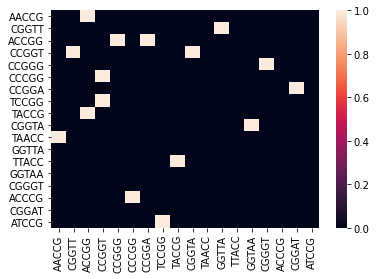

In [1953]:
l_contingency = dgraph_5p_to_3p.copy()
r_contingency = dgraph_5p_to_3p.T.copy()

sns.heatmap(l_contingency)

<AxesSubplot:>

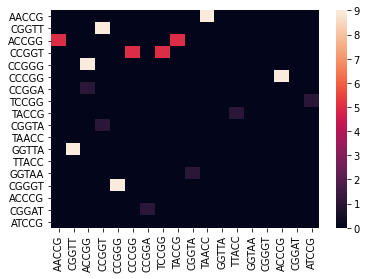

In [1954]:
# Initialization

send_to_r = r_contingency
send_to_l = l_contingency

# This is not actually the flow,
# because it's not proportional to depth...yet.

depth = depth0

total_from_l = send_to_r.sum()
total_from_r = send_to_l.sum()

# When it's not initialization
# we'll update depth here.

send_to_r_next = (send_to_l / total_from_r).multiply(depth, axis=1).T
send_to_l_next = (send_to_r / total_from_l).multiply(depth, axis=1).T

# Initialization done
send_to_r = send_to_r_next.fillna(0)
send_to_l = send_to_l_next.fillna(0)

sns.heatmap(send_to_r)

# table = pd.DataFrame(dict(depth=depth, in_degree_r=total_from_r, in_degree_l=total_from_l, out_degree_r=send_to_r.sum(1), out_degree_l=send_to_l.sum(1)))
# table

In [1993]:
# One Step
total_from_l = send_to_r.sum()
total_from_r = send_to_l.sum()

# Graveyard of depths past.
# depth = np.sqrt(np.mean((np.array([total_from_r, total_from_l, depth]) + 1)**2))  #  (depth0 * gamma + depth + total_from_r + total_from_l) / (3 + gamma)
# next_depth = np.cbrt((total_from_r + pc) * (total_from_l + pc) * (depth + pc)) - pc
# depth = (
#     np.exp(
#         (
#             np.log(total_from_r + pc) +
#             np.log(total_from_l + pc) +
#             np.log(depth + pc)
#         ) / (3 + pc)
#     )
# )

# Update depth
gamma = 1
next_depth = (total_from_r + total_from_l + (gamma * depth)) / (2 + gamma)
# Scale the depth so there's no overall loss.
depth = next_depth * (depth.sum() / next_depth.sum())

send_to_r_next = (send_to_l / total_from_r).multiply(depth, axis=1).T
send_to_l_next = (send_to_r / total_from_l).multiply(depth, axis=1).T

send_to_r = send_to_r_next.fillna(0)
send_to_l = send_to_l_next.fillna(0)

# Step done

# sns.heatmap(send_to_r)
# plt.plot(depth)
# plt.ylim(0)
depth

# table = pd.DataFrame(dict(depth=depth, in_degree_r=total_from_r, in_degree_l=total_from_l, out_degree_r=send_to_r.sum(1), out_degree_l=send_to_l.sum(1)))
# table

AACCG     9.566258
CGGTT     9.566258
ACCGG    13.397460
CCGGT    13.397460
CCGGG     9.566258
CCCGG     9.566258
CCGGA     2.036282
TCCGG     2.036282
TACCG     2.036282
CGGTA     2.036282
TAACC     5.523082
GGTTA     5.523082
TTACC     1.175648
GGTAA     1.175648
CGGGT     5.523082
ACCCG     5.523082
CGGAT     1.175648
ATCCG     1.175648
dtype: float64

# Six-cycle

In [2005]:
seed = {
    'ACCCG': ['CCCGG'],
    'CCCGG': ['CCGGA'],
    'CCGGA': ['CGGAC'],
    'CGGAC': ['GGACC'],
    'GGACC': ['GACCC'],
    'GACCC': ['ACCCG']
}
downstream, upstream = lib.assembly_graph.build_full_from_seed_graph(seed)

observed_depth = lib.assembly_graph.add_reverse_complement_depth({
    'ACCCG': 1,
    'CCCGG': 1,
    'CCGGA': 2,
    'CGGAC': 1,
    'GGACC': 1,
    'GACCC': 1,
})

assert lib.assembly_graph.mapping_all_upstream(upstream)
upstream, observed_depth

(defaultdict(list,
             {'CCCGG': ['ACCCG'],
              'CGGGT': ['CCGGG'],
              'CCGGA': ['CCCGG'],
              'CCGGG': ['TCCGG'],
              'CGGAC': ['CCGGA'],
              'TCCGG': ['GTCCG'],
              'GGACC': ['CGGAC'],
              'GTCCG': ['GGTCC'],
              'GACCC': ['GGACC'],
              'GGTCC': ['GGGTC'],
              'ACCCG': ['GACCC'],
              'GGGTC': ['CGGGT']}),
 defaultdict(<function lib.assembly_graph.add_reverse_complement_depth.<locals>.<lambda>()>,
             {'ACCCG': 1,
              'CGGGT': 1,
              'CCCGG': 1,
              'CCGGG': 1,
              'CCGGA': 2,
              'TCCGG': 2,
              'CGGAC': 1,
              'GTCCG': 1,
              'GGACC': 1,
              'GGTCC': 1,
              'GACCC': 1,
              'GGGTC': 1}))

In [2006]:
depth0 = pd.Series(observed_depth).astype(float)
n = len(depth0)
depth0

ACCCG    1.0
CGGGT    1.0
CCCGG    1.0
CCGGG    1.0
CCGGA    2.0
TCCGG    2.0
CGGAC    1.0
GTCCG    1.0
GGACC    1.0
GGTCC    1.0
GACCC    1.0
GGGTC    1.0
dtype: float64

In [2007]:
# "Directed" graph with each node pointing to nodes that are downstream.
# If I want a graph of each node pointing upstream, that's just dgraph.T
# After the *first* step, where I distribute each nodes depth equally upstream
# and downstream, I'm going to need two contingency tables, because
# uflow != dflow.T

linked_5p_to_3p = downstream

dgraph_5p_to_3p = pd.DataFrame(np.zeros((n, n)), index=depth0.index, columns=depth0.index)
for k in dgraph_5p_to_3p:
    dgraph_5p_to_3p.loc[k, linked_5p_to_3p[k]] = 1

<AxesSubplot:>

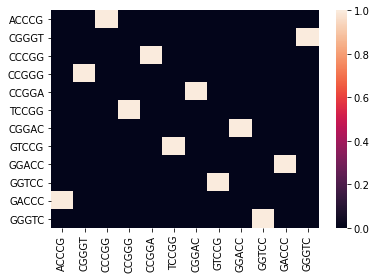

In [2008]:
l_contingency = dgraph_5p_to_3p.copy()
r_contingency = dgraph_5p_to_3p.T.copy()

sns.heatmap(l_contingency)

<AxesSubplot:>

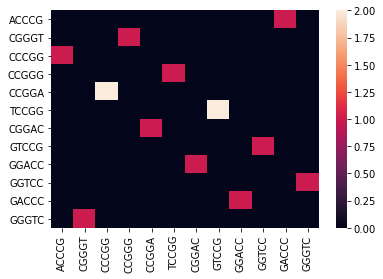

In [2009]:
# Initialization

send_to_r = r_contingency
send_to_l = l_contingency

# This is not actually the flow,
# because it's not proportional to depth...yet.

depth = depth0

total_from_l = send_to_r.sum()
total_from_r = send_to_l.sum()

# When it's not initialization
# we'll update depth here.

send_to_r_next = (send_to_l / total_from_r).multiply(depth, axis=1).T
send_to_l_next = (send_to_r / total_from_l).multiply(depth, axis=1).T

# Initialization done
send_to_r = send_to_r_next.fillna(0)
send_to_l = send_to_l_next.fillna(0)

sns.heatmap(send_to_r)

# table = pd.DataFrame(dict(depth=depth, in_degree_r=total_from_r, in_degree_l=total_from_l, out_degree_r=send_to_r.sum(1), out_degree_l=send_to_l.sum(1)))
# table

In [2050]:
# One Step
total_from_l = send_to_r.sum()
total_from_r = send_to_l.sum()

# Graveyard of depths past.
# depth = np.sqrt(np.mean((np.array([total_from_r, total_from_l, depth]) + 1)**2))  #  (depth0 * gamma + depth + total_from_r + total_from_l) / (3 + gamma)
# next_depth = np.cbrt((total_from_r + pc) * (total_from_l + pc) * (depth + pc)) - pc
# depth = (
#     np.exp(
#         (
#             np.log(total_from_r + pc) +
#             np.log(total_from_l + pc) +
#             np.log(depth + pc)
#         ) / (3 + pc)
#     )
# )

# Update depth
gamma = 1
next_depth = (total_from_r + total_from_l + (gamma * depth)) / (2 + gamma)
# Scale the depth so there's no overall loss.
depth = next_depth * (depth.sum() / next_depth.sum())

send_to_r_next = (send_to_l / total_from_r).multiply(depth, axis=1).T
send_to_l_next = (send_to_r / total_from_l).multiply(depth, axis=1).T

send_to_r = send_to_r_next.fillna(0)
send_to_l = send_to_l_next.fillna(0)

# Step done

# sns.heatmap(send_to_r)
# plt.plot(depth)
# plt.ylim(0)
depth

# table = pd.DataFrame(dict(depth=depth, in_degree_r=total_from_r, in_degree_l=total_from_l, out_degree_r=send_to_r.sum(1), out_degree_l=send_to_l.sum(1)))
# table

ACCCG    1.166667
CGGGT    1.166667
CCCGG    1.166667
CCGGG    1.166667
CCGGA    1.166667
TCCGG    1.166667
CGGAC    1.166667
GTCCG    1.166667
GGACC    1.166667
GGTCC    1.166667
GACCC    1.166667
GGGTC    1.166667
dtype: float64

# Double-six-cycle

In [2198]:
seed = {
    # Top cycle
    'GGACC': ['GACCC'],
    'GACCC': ['ACCCG'],
    'ACCCG': ['CCCGG'],
    'CCCGG': ['CCGGA'],
    'CCGGA': ['CGGAC'],
    
    # Link
    'CGGAC': ['GGACC', 'GGACT'],
    
    # Bottom cycle
    'GGACT': ['GACTC'],
    'GACTC': ['ACTCG'],
    'ACTCG': ['CTCGG'],
    'CTCGG': ['TCGGA'],
    'TCGGA': ['CGGAC'],
    
}
downstream, upstream = lib.assembly_graph.build_full_from_seed_graph(seed)

observed_depth = lib.assembly_graph.add_reverse_complement_depth({
    # Top cycle
    'GGACC': 1,
    'GACCC': 1,
    'ACCCG': 1,
    'CCCGG': 1,
    'CCGGA': 1,
    
    # Link
    'CGGAC': 1,
    
    # Bottom 
    'GGACT': 2, 
    'GACTC': 2,
    'ACTCG': 2,
    'CTCGG': 2,
    'TCGGA': 2,
})

assert lib.assembly_graph.mapping_all_upstream(upstream)
upstream, observed_depth

(defaultdict(list,
             {'GACCC': ['GGACC'],
              'GGTCC': ['GGGTC'],
              'ACCCG': ['GACCC'],
              'GGGTC': ['CGGGT'],
              'CCCGG': ['ACCCG'],
              'CGGGT': ['CCGGG'],
              'CCGGA': ['CCCGG'],
              'CCGGG': ['TCCGG'],
              'CGGAC': ['CCGGA', 'TCGGA'],
              'TCCGG': ['GTCCG'],
              'GGACC': ['CGGAC'],
              'GTCCG': ['GGTCC', 'AGTCC'],
              'GGACT': ['CGGAC'],
              'GACTC': ['GGACT'],
              'AGTCC': ['GAGTC'],
              'ACTCG': ['GACTC'],
              'GAGTC': ['CGAGT'],
              'CTCGG': ['ACTCG'],
              'CGAGT': ['CCGAG'],
              'TCGGA': ['CTCGG'],
              'CCGAG': ['TCCGA'],
              'TCCGA': ['GTCCG']}),
 defaultdict(<function lib.assembly_graph.add_reverse_complement_depth.<locals>.<lambda>()>,
             {'GGACC': 1,
              'GGTCC': 1,
              'GACCC': 1,
              'GGGTC': 1,
              'A

In [2199]:
depth0 = pd.Series(observed_depth).astype(float)
n = len(depth0)
depth0

GGACC    1.0
GGTCC    1.0
GACCC    1.0
GGGTC    1.0
ACCCG    1.0
CGGGT    1.0
CCCGG    1.0
CCGGG    1.0
CCGGA    1.0
TCCGG    1.0
CGGAC    1.0
GTCCG    1.0
GGACT    2.0
AGTCC    2.0
GACTC    2.0
GAGTC    2.0
ACTCG    2.0
CGAGT    2.0
CTCGG    2.0
CCGAG    2.0
TCGGA    2.0
TCCGA    2.0
dtype: float64

In [2200]:
# "Directed" graph with each node pointing to nodes that are downstream.
# If I want a graph of each node pointing upstream, that's just dgraph.T
# After the *first* step, where I distribute each nodes depth equally upstream
# and downstream, I'm going to need two contingency tables, because
# uflow != dflow.T

linked_5p_to_3p = downstream

dgraph_5p_to_3p = pd.DataFrame(np.zeros((n, n)), index=depth0.index, columns=depth0.index)
for k in dgraph_5p_to_3p:
    dgraph_5p_to_3p.loc[k, linked_5p_to_3p[k]] = 1

<AxesSubplot:>

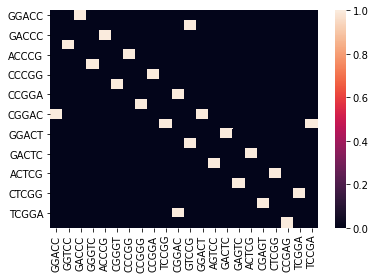

In [2201]:
l_contingency = dgraph_5p_to_3p.copy()
r_contingency = dgraph_5p_to_3p.T.copy()

sns.heatmap(l_contingency)

<AxesSubplot:>

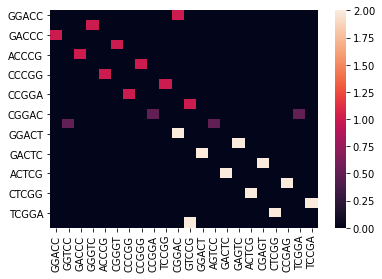

In [2202]:
# Initialization

send_to_r = r_contingency
send_to_l = l_contingency

# This is not actually the flow,
# because it's not proportional to depth...yet.

depth = depth0

total_from_l = send_to_r.sum()
total_from_r = send_to_l.sum()

# When it's not initialization
# we'll update depth here.

send_to_r_next = (send_to_l / total_from_r).multiply(depth, axis=1).T
send_to_l_next = (send_to_r / total_from_l).multiply(depth, axis=1).T

# Initialization done
send_to_r = send_to_r_next.fillna(0)
send_to_l = send_to_l_next.fillna(0)

sns.heatmap(send_to_r)

# table = pd.DataFrame(dict(depth=depth, in_degree_r=total_from_r, in_degree_l=total_from_l, out_degree_r=send_to_r.sum(1), out_degree_l=send_to_l.sum(1)))
# table

In [2238]:
# One Step
total_from_l = send_to_r.sum()
total_from_r = send_to_l.sum()

# Graveyard of depths past.
# depth = np.sqrt(np.mean((np.array([total_from_r, total_from_l, depth]) + 1)**2))  #  (depth0 * gamma + depth + total_from_r + total_from_l) / (3 + gamma)
# next_depth = np.cbrt((total_from_r + pc) * (total_from_l + pc) * (depth + pc)) - pc
# depth = (
#     np.exp(
#         (
#             np.log(total_from_r + pc) +
#             np.log(total_from_l + pc) +
#             np.log(depth + pc)
#         ) / (3 + pc)
#     )
# )

# Update depth
gamma = 10
next_depth = (total_from_r + total_from_l + (gamma * depth)) / (2 + gamma)
# Scale the depth so there's no overall loss.
depth = next_depth * (depth.sum() / next_depth.sum())

send_to_r_next = (send_to_l / total_from_r).multiply(depth, axis=1).T
send_to_l_next = (send_to_r / total_from_l).multiply(depth, axis=1).T

send_to_r = send_to_r_next.fillna(0)
send_to_l = send_to_l_next.fillna(0)

# Step done

# sns.heatmap(send_to_r)
# plt.plot(depth)
# plt.ylim(0)
depth

# table = pd.DataFrame(dict(depth=depth, in_degree_r=total_from_r, in_degree_l=total_from_l, out_degree_r=send_to_r.sum(1), out_degree_l=send_to_l.sum(1)))
# table

GGACC    0.888744
GGTCC    0.888744
GACCC    0.898343
GGGTC    0.898343
ACCCG    0.903118
CGGGT    0.903118
CCCGG    0.898343
CCGGG    0.898343
CCGGA    0.888744
TCCGG    0.888744
CGGAC    2.637570
GTCCG    2.637570
GGACT    1.763396
AGTCC    1.763396
GACTC    1.782872
GAGTC    1.782872
ACTCG    1.792603
CGAGT    1.792603
CTCGG    1.782872
CCGAG    1.782872
TCGGA    1.763396
TCCGA    1.763396
dtype: float64